In [1]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
conn = MongoClient('140.115.53.147', 27017)
conn.database_names()

C:\Users\Liuya\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: database_names is deprecated. Use list_database_names instead.
  


['107_ELK',
 'AU_106_2_BIO',
 'AU_106_2_SE',
 'CYCU_1031SP',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU_dataset_1',
 'KU_dataset_2',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'admin',
 'config',
 'local',
 'test']

In [3]:
db = conn['NCUx107_Pre_college_calculas']
collection = db['ma_w8_avg.csv']
pref = pd.DataFrame(list(collection.find()))
pref.head()

,_id,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,...,video_pause_sum,video_play_avg,video_play_sum,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday
0,5bbb5aef9e0c6c62035b7d6f,2.500000,0.125,2.500,0.000000,0.000,0.000000,0.000,0.000000,0.00,...,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.125,0.000000,0.000
1,5bbb5aef9e0c6c62035b7d70,0.250000,0.125,0.250,0.000000,0.000,0.000000,0.000,0.000000,0.00,...,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000
2,5bbb5aef9e0c6c62035b7d71,99.604167,2.500,267.375,1.670238,10.875,2.357738,14.625,4.027976,25.50,...,15.750,4.777976,30.125,0.122917,0.035417,0.250,1.000,33.250,7.560717,4.500
3,5bbb5aef9e0c6c62035b7d72,0.250000,0.125,0.250,0.000000,0.000,0.000000,0.000,0.000000,0.00,...,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000
4,5bbb5aef9e0c6c62035b7d73,67.770833,2.250,164.250,1.020833,5.375,2.871528,11.375,3.892361,16.75,...,10.875,4.267361,18.500,0.059028,0.031250,0.125,0.375,20.125,4.630036,1.625


In [4]:
pref = pref.drop(['_id'], axis=1)
pref = pref.drop(['email'], axis=1)
pref = pref.drop(['course_id'], axis=1)
pref.head()

,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,complete_rate,...,video_pause_sum,video_play_avg,video_play_sum,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday
0,2.500000,0.125,2.500,0.000000,0.000,0.000000,0.000,0.000000,0.00,0.000000,...,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.125,0.000000,0.000
1,0.250000,0.125,0.250,0.000000,0.000,0.000000,0.000,0.000000,0.00,0.000000,...,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000
2,99.604167,2.500,267.375,1.670238,10.875,2.357738,14.625,4.027976,25.50,0.567262,...,15.750,4.777976,30.125,0.122917,0.035417,0.250,1.000,33.250,7.560717,4.500
3,0.250000,0.125,0.250,0.000000,0.000,0.000000,0.000,0.000000,0.00,0.000000,...,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000
4,67.770833,2.250,164.250,1.020833,5.375,2.871528,11.375,3.892361,16.75,0.329861,...,10.875,4.267361,18.500,0.059028,0.031250,0.125,0.375,20.125,4.630036,1.625


In [5]:
collection = db['students_grades']
preg = pd.DataFrame(list(collection.find()))
preg.head()

,_id,bonusGrade,finalScore,grades,name,rollCallGrade,stageGrade,studentId
0,5bbb5dcc9e0c6c62035b8bf6,0,82,"[{'name': '週考一', 'score': 86}, {'name': '週考二',...",薛瀚軒,11,2,107203516
1,5bbb5dcc9e0c6c62035b8bf7,11.5,82,"[{'name': '週考一', 'score': 86}, {'name': '週考二',...",李思杰,10,4,107202510
2,5bbb5dcc9e0c6c62035b8bf8,10,64,"[{'name': '週考一', 'score': 75}, {'name': '週考二',...",林家宏,11,5,107202506
3,5bbb5dcc9e0c6c62035b8bf9,4.5,72,"[{'name': '週考一', 'score': 90}, {'name': '週考二',...",呂祐任,11,2,107203518
4,5bbb5dcc9e0c6c62035b8bfa,8,77,"[{'name': '週考一', 'score': 78}, {'name': '週考二',...",賴郁宜,10,3,107206504


In [6]:
preg=preg.drop('_id',axis=1)
preg=preg.drop('bonusGrade',axis=1)
preg=preg.drop('grades',axis=1)
preg=preg.drop('name',axis=1)
preg=preg.drop('rollCallGrade',axis=1)
preg=preg.drop('stageGrade',axis=1)

In [7]:
preg['username']=preg['studentId']
preg=preg.drop('studentId',axis=1)
preg.head()

,finalScore,username
0,82,107203516
1,82,107202510
2,64,107202506
3,72,107203518
4,77,107206504


In [8]:
pre=pd.merge(pref,preg,on='username')
pre=pre.drop('username',axis=1)
list(pre)

['active_avg_count',
 'active_num_days',
 'active_sum_count',
 'all_type_video_backward_seek_avg',
 'all_type_video_backward_seek_sum',
 'all_type_video_forward_seek_avg',
 'all_type_video_forward_seek_sum',
 'all_type_video_seek_avg',
 'all_type_video_seek_sum',
 'complete_rate',
 'forum_avg_count',
 'forum_num_days',
 'forum_sum_count',
 'incomplete_rate',
 'num_complete',
 'num_days',
 'num_incomplete',
 'num_watched',
 'pause_video_avg',
 'pause_video_sum',
 'problem_avg_count',
 'problem_num_days',
 'problem_sum_count',
 'seek_video_avg',
 'seek_video_sum',
 'stop_video_avg',
 'stop_video_sum',
 'video_avg_count',
 'video_backward_seek_avg',
 'video_backward_seek_sum',
 'video_events_avg',
 'video_events_sum',
 'video_forward_seek_avg',
 'video_forward_seek_sum',
 'video_num_days',
 'video_pause_avg',
 'video_pause_backward_seek_avg',
 'video_pause_backward_seek_sum',
 'video_pause_forward_seek_avg',
 'video_pause_forward_seek_sum',
 'video_pause_sum',
 'video_play_avg',
 'video_p

In [9]:
data=pre
data['class']=data['finalScore'] < 60
data=data.drop(['finalScore'],axis=1)

In [10]:
data

,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,complete_rate,...,video_play_avg,video_play_sum,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday,class
0,104.238095,5.750,690.500,1.422115,7.750,12.048397,43.750,13.470513,51.500,0.638141,...,14.345513,56.000,0.088782,0.025000,0.250,0.625,58.000,7.865671,4.125,False
1,16.500000,0.250,16.500,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000,True
2,105.812500,0.750,106.375,0.075000,0.750,0.050000,0.500,0.125000,1.250,0.125000,...,0.250000,2.500,0.075000,0.000000,0.000,0.750,2.750,0.683710,0.875,False
3,6.937500,0.750,8.500,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000,False
4,29.812500,2.875,104.750,0.310714,1.875,1.392857,4.250,1.703571,6.125,0.375000,...,2.078571,7.750,0.103571,0.025000,0.125,0.625,8.000,2.087674,1.500,False
5,34.125000,1.125,65.125,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.062500,...,0.125000,0.250,0.062500,0.000000,0.000,0.125,0.875,0.377559,0.625,True
6,15.187500,0.500,17.000,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,...,0.125000,0.125,0.000000,0.000000,0.000,0.000,0.250,0.343473,0.625,True
7,80.479167,2.375,348.125,0.239583,0.750,0.958333,3.125,1.197917,3.875,0.114583,...,1.572917,5.500,0.000000,0.000000,0.000,0.000,7.250,3.440801,0.625,False
8,82.343750,1.250,276.750,1.075000,2.375,6.200000,11.000,7.275000,13.375,0.025000,...,7.525000,14.125,0.000000,0.000000,0.000,0.000,14.500,1.961065,0.750,False
9,245.425000,3.125,962.750,2.897864,41.625,5.531684,91.625,8.429548,133.250,0.713673,...,9.179548,145.250,0.283529,0.057607,1.125,4.750,143.625,8.289162,3.250,False


In [11]:
# Import some data to play with
#iris = datasets.load_iris()

#kyoto_y = kyoto_1['score']
#kyoto_x = kyoto_1.drop(['score'], axis=1)

X = data.drop(['class'], axis=1)
y = data['class']
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

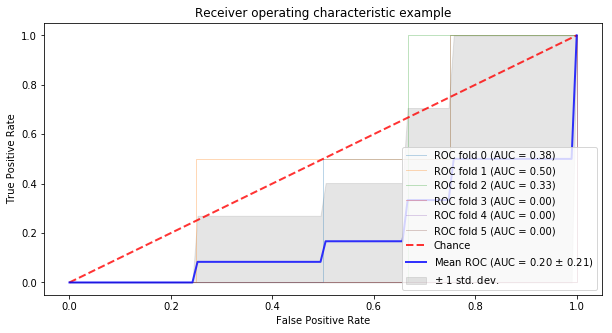

In [12]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 5))

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()